# 6 模型构建

- 架构

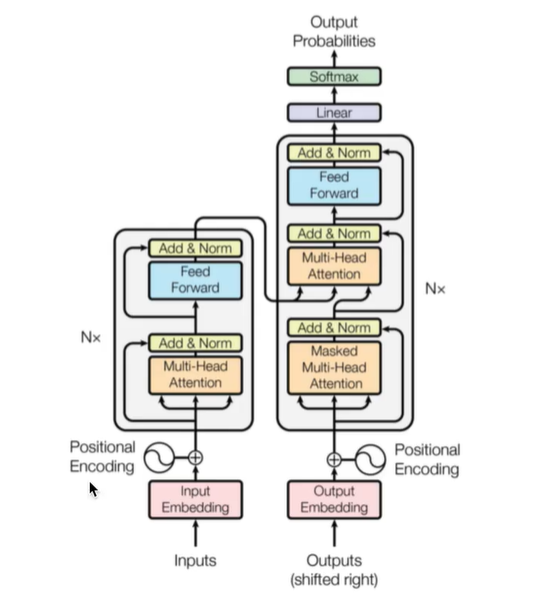

- 代码实现

In [ ]:
# 使用EncoderDecoder类来实现编码器-解码器结构
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder, source_embed, target_embed, generator):
        """
        初始化函数中有5个参数，
        分别是编码器对象，解码器对象，源数据嵌入函数，目标数据嵌入函数，
        以及输出部分的类别生成器对象
        """
        super(EncoderDecoder, self).__init__()  
        # 将参数传入到类中
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = source_embed
        self.tgt_embed = target_embed
        self.generator = generator
    
    def forward(self, source, target, source_mask, target_mask):
        """
        在forward函数中，有四个参数，
        source代表源数据，target代表目标数据，
        source_mask和target_mask代表对应的掩码张量
        """
        # 在函数中，将source，source_mask传入编码函数，得到结果后
        # 与source_mask，target，和target_mask一同传给解码函数
        return self.decode(self.encode(source, source_mask), 
        source_mask, target, target_mask)
    
    def encode(self, source, source_mask):
        """编码函数，以source和source_mask为参数"""
        # 使用src_embed对source做处理:词嵌入
        # 然后和source_mask一起传给self.encoder
        return self.encoder(self.src_embed(source), source_mask)
    
    def decode(self, memory, source_mask, target, target_mask):
        """解码函数，以memory即编码器的输出，source_mask，target，target_mask为参数"""
        # 使用tgt_embed对target做处理，然后和source_mask，target_mask，memory一起传给self.decoder
        return self.decoder(self.tgt_embed(target), memory, source_mask, target_mask)


In [ ]:
import torch.nn as nn
import torch

# Example parameters
vocab_size = 1000
d_model = 512

encoder = Encoder(...)
decoder = Decoder(...)

source_embed = nn.Embedding(vocab_size, d_model)
target_embed = nn.Embedding(vocab_size, d_model)
generator = Generator(...)

source = target = torch.LongTensor([[1, 2, 3, 4, 5],[1, 2, 3, 4, 5]])

source_mask = target_mask = torch.zeros(8,4,4)

# Create an instance of EncoderDecoder
ed_model = EncoderDecoder(encoder, decoder, source_embed, target_embed, generator)
output = ed_model(source, target, source_mask, target_mask)


# 完整代码

In [17]:
import torch.nn as nn
import torch
import math
import torch.nn.functional as F

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class TransformerModel(nn.Module):
    def __init__(self, ntoken, d_model, nhead, nhid, nlayers, dropout=0.5):
        """
        初始化TransformerModel类的实例。

        参数：
        - ntoken：词汇表的大小
        - d_model：模型的维度大小
        - nhead：多头注意力的头数
        - nhid：前馈神经网络的隐藏层大小
        - nlayers：编码器的层数
        - dropout：Dropout层的丢弃率
        """
        
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(d_model, dropout)

        '''这两段代码是用于构建整体的Transformer模型的。

            第一段代码创建了一个nn.TransformerEncoderLayer对象，它是Transformer模型中的一个关键组件。
            这个对象接受几个参数，包括d_model（模型的输入和输出维度）、nhead（多头注意力机制的头数）、
            nhid（前馈神经网络的隐藏层维度）和dropout（用于正则化的丢弃率）。
            这个对象定义了一个Transformer编码器层，它包含了多头自注意力机制和前馈神经网络。

            第二段代码创建了一个nn.TransformerEncoder对象，它是整体的Transformer编码器。
            这个对象接受两个参数，第一个参数是之前创建的nn.TransformerEncoderLayer对象，用于定义编码器层的结构，
            第二个参数是nlayers，表示编码器中的层数。这个对象将多个编码器层堆叠在一起，形成整体的Transformer编码器。

            通过这两段代码，我们可以构建一个包含多个编码器层的Transformer模型，用于处理序列数据的编码和特征提取。'''
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, nhid, dropout) # 这里包括多头注意力机制和前馈神经网络
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, nlayers) # 复制n层


        decoder_layers = nn.TransformerDecoderLayer(d_model, nhead, nhid, dropout)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layers, nlayers)

        self.embd = nn.Embedding(ntoken, d_model)
        self.d_model = d_model
        
    def _generate_square_subsequent_mask(self, sz):
        # 生成一个方形的上三角遮罩矩阵
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        # 将遮罩矩阵转换为浮点类型，并将其中的0值替换为负无穷，将其中的1值替换为0
        # 这样在进行softmax操作时，遮罩矩阵中的0值对应的位置会得到一个非常小的数值，而1值对应的位置会得到0
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask
    
    def forward(self, src, tgt):

        '''下面这段代码的作用：
        首先，代码检查了一个名为self.src_mask的属性是否为None，或者是否与src的长度不匹配。self.src_mask是一个用于遮罩操作的张量。

        如果self.src_mask为None或者长度不匹配，那么代码会执行以下操作：

        a. 获取src的设备信息，即它所在的计算设备（如CPU或GPU）。

        b. 调用一个名为_generate_square_subsequent_mask的方法，该方法会生成一个方形的上三角遮罩矩阵。
        这个遮罩矩阵用于在Transformer模型中屏蔽未来的信息，以便模型只能看到当前和过去的输入。

        c. 将生成的遮罩矩阵转移到与src相同的设备上。

        d. 将生成的遮罩矩阵赋值给self.src_mask属性，以便在后续的操作中使用。

        这段代码的作用是确保self.src_mask属性存在并且与src的长度匹配。如果不匹配，就会生成一个新的遮罩矩阵并赋值给self.src_mask属性。
        这样可以确保在后续的代码中使用正确的遮罩矩阵。'''
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask
        
        '''在这段代码中，src = self.encoder(src) * math.sqrt(self.d_model)，
        乘以math.sqrt(self.d_model)的目的是为了缩放嵌入向量的数值范围。

        在Transformer模型中，嵌入层用于将离散的输入类别（如单词或标签）映射到连续的向量表示。这些嵌入向量的维度由d_model参数指定。

        通过乘以math.sqrt(self.d_model)，可以缩放嵌入向量的数值范围。
        这是因为在Transformer模型中，嵌入向量与位置编码向量相加后，会传递给编码器进行处理。
        如果嵌入向量的数值范围过大，可能会导致梯度消失或梯度爆炸的问题。通过缩放嵌入向量，可以在一定程度上缓解这些问题，提高模型的训练效果和稳定性。

        总结起来，乘以math.sqrt(self.d_model)是为了缩放嵌入向量的数值范围，以提高模型的训练效果和稳定性。'''
        # 对源数据和目标数据进行词嵌入
        src = self.embd(src) * math.sqrt(self.d_model)
        tgt = self.embd(tgt) * math.sqrt(self.d_model)

        # 对源数据和目标数据进行位置编码
        pe_src = self.pos_encoder(src)
        pe_tgt = self.pos_encoder(tgt)

        # 编码器,输入位置编码+遮掩
        encoder_output = self.transformer_encoder(pe_src, self.src_mask)
        # 解码器,输入目标位置编码+编码器输出+遮掩
        decoder_output = self.transformer_decoder(pe_tgt, encoder_output, self.src_mask)

        # 这里还差一个线性层
        return F.log_softmax(decoder_output, dim=-1)


In [19]:
# Construct parameters
'''
ntoken: 这是一个整数，表示词汇表的大小。在这个模型中，词汇表的大小为1000，意味着输入数据将由1000个不同的词。

d_model: 词嵌入维度. Each token（词） will be represented as a vector of this size.。

nhead: 这是一个整数，表示多头自注意力机制中的注意力头数。自注意力机制是Transformer模型的核心组件之一，它允许模型在处理输入序列时同时关注不同位置的信息。在这个模型中，使用了8个注意力头。

nhid: 这也是一个整数，表示Transformer模型中全连接层的隐藏层维度。全连接层用于在模型的编码和解码过程中进行特征转换和映射。在这个模型中，全连接层的隐藏层维度为2048。

nlayers: 这是一个整数，表示Transformer模型中的编码器和解码器的层数。编码器和解码器是Transformer模型的两个主要组件，它们分别负责对输入数据进行编码和解码。在这个模型中，编码器和解码器的层数都为6。

dropout: 这是一个浮点数，表示在模型的训练过程中进行随机失活的比例。随机失活是一种正则化技术，用于防止模型在训练过程中出现过拟合。在这个模型中，随机失活的比例为0.5。'''
ntoken = 1000
# 目标词汇总数 ntoken_2
d_model = 512
nhead = 8
nhid = 2048 #dff
nlayers = 6
dropout = 0.5

# Create an instance of the TransformerModel
transformer = TransformerModel(ntoken, d_model, nhead, nhid, nlayers, dropout)

# 在文本翻译任务中，source和tgt是表示源语言和目标语言的句子的张量（tensor）。

# source是一个包含源语言句子的张量。在这个例子中，source是一个形状为(2, 5)的张量，
# 其中每一行代表一个源语言句子。每个句子由一系列单词的索引组成，这些索引表示单词在词汇表中的位置。

# tgt是一个包含目标语言句子的张量。在这个例子中，tgt是一个形状为(2, 5)的张量，其中每一行代表一个目标语言句子。
# 训练过程中，tgt通常是作为训练数据的一部分提供的。它包含了目标语言句子的单词索引，用于训练模型生成翻译结果。
# 在实际应用中，tgt可以是人工标注的翻译结果或者其他可用的目标语言数据。
source = torch.LongTensor([[1, 2, 3, 4, 5],[1, 2, 3, 4, 5]])
tgt = torch.LongTensor([[6, 7, 8, 9, 10],[6, 7, 8, 9, 10]])  # Add this line

output = transformer(source, tgt)  # Modify this line
print(output)
print(output.shape)
'''output.shape返回的是output张量的形状。在这个例子中，output的形状是[2, 5, 512]。

第一个维度（2）表示批处理大小，即同时处理的样本数量。在这个例子中，有两个样本被同时处理。
第二个维度（5）表示输出序列的长度。在这个例子中，输出序列的长度为5。
第三个维度（512）表示词嵌入维度（d_model），即每个词被表示为一个512维的向量。'''


tensor([[[ -7.7688,  -6.5861,  -5.5426,  ...,  -8.0750,  -5.8772,  -7.4358],
         [ -8.0411,  -6.7640,  -5.7559,  ...,  -7.2941,  -7.6461,  -7.6059],
         [ -7.5228,  -7.3962,  -6.8921,  ...,  -6.6127,  -8.3995,  -6.0919],
         [ -6.0163, -10.0281,  -7.5657,  ...,  -5.7777,  -5.9535,  -6.2611],
         [ -7.5881,  -7.5832,  -6.2853,  ...,  -5.9064,  -6.6835,  -7.4614]],

        [[ -7.4699,  -8.0624,  -5.6345,  ...,  -8.2384,  -6.0511,  -7.2615],
         [ -6.4240,  -6.3114,  -5.7206,  ...,  -6.6935,  -8.0127,  -7.0251],
         [ -5.9996,  -5.6469,  -7.0103,  ...,  -8.1645,  -8.0336,  -6.0483],
         [ -6.0664,  -6.6588,  -6.8088,  ...,  -6.7048,  -6.0902,  -6.2373],
         [ -7.5985,  -6.9563,  -7.4874,  ...,  -6.8018,  -6.6520,  -7.8629]]],
       grad_fn=<LogSoftmaxBackward0>)
torch.Size([2, 5, 512])


f:\Anaconda-env\LLMpython39\lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


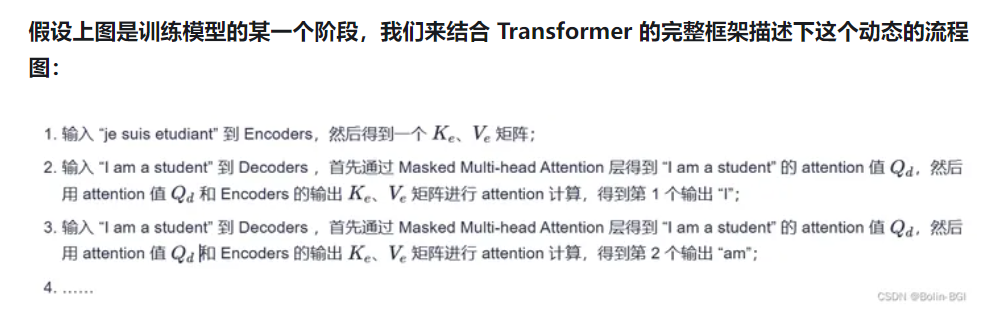

有7个参数，分别是源数据特征(词汇)总数，目标数据特征(词汇)总数，编码器和解码器堆叠数，词向量映射维度，前馈全连接网络中变换矩阵的维度，多头注意力结构中的多头数，以及置零比率dropout.

问题：我不知道结果的含义